# 1. Загрузка данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn

In [3]:
train = pd.read_csv('Data/train.csv', low_memory=False)
train.index.name = 'Index'
test = pd.read_csv('Data/test.csv', low_memory=False)
test.index.name = 'Index'

In [4]:
rawData = pd.concat([train, test], sort=False)

In [5]:
categoricalFeatures = ["hour","weekday","month","year","season","weather","holiday","workingday"]
numericalFeatures = ["atemp", "humidity", "windspeed", "count"]
featuresToBeDropped = ["temp", "registered", "casual", "datetime", "count"]

# 2. Инженерия признаков

In [6]:
#Create year, month, day, time columns
rawData['year'] = pd.to_datetime(rawData['datetime']).apply(lambda x : x.year)
rawData['month'] = pd.to_datetime(rawData['datetime']).apply(lambda x : x.month)
rawData['weekday'] = pd.to_datetime(rawData['datetime']).apply(lambda x : x.isoweekday())
rawData['hour'] = pd.to_datetime(rawData['datetime']).apply(lambda x : x.hour)

In [7]:
for var in categoricalFeatures:
    rawData[var] = rawData[var].astype("category")

In [8]:
def convert_col_to_dummy_df(df_col):
    col_name = df_col.name
    # Add calculating frequencies of values here...
    dummy_df = pd.get_dummies(df_col, prefix=col_name, prefix_sep=': ')
    dummy_df_cols = {}
    # Add formatting names here...
    return dummy_df

# 5. Encode categorical features
for col_name in rawData.columns:
    col_series = rawData[col_name]
    if col_series.dtype.name == 'category':
        print('Applying categorical encoding to %s...' % col_name)
        dummy_df = convert_col_to_dummy_df(col_series)
        rawData.drop(col_name, axis=1, inplace=True)
        rawData = pd.concat([rawData, dummy_df], axis=1)

Applying categorical encoding to season...
Applying categorical encoding to holiday...
Applying categorical encoding to workingday...
Applying categorical encoding to weather...
Applying categorical encoding to year...
Applying categorical encoding to month...
Applying categorical encoding to weekday...
Applying categorical encoding to hour...


In [9]:
dataTrain = rawData[pd.notnull(rawData['count'])].sort_values(by=["datetime"])
#dataTrain = dataTrain[np.abs(dataTrain["count"]-dataTrain["count"].mean()) <= (3*dataTrain["count"].std())]
dataTest = rawData[~pd.notnull(rawData['count'])].sort_values(by=["datetime"])
labels = dataTrain["count"]
datetime = dataTest["datetime"]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( dataTrain, labels, test_size=0.3, random_state=42)

In [11]:
dataTrain  = dataTrain.drop(featuresToBeDropped,axis=1)
dataTest  = dataTest.drop(featuresToBeDropped,axis=1)
X_train = X_train.drop(featuresToBeDropped,axis=1)
X_validate = X_validate.drop(featuresToBeDropped,axis=1)

In [12]:
X_train.head()

,atemp,humidity,windspeed,season: 1,season: 2,season: 3,season: 4,holiday: 0,holiday: 1,workingday: 0,...,hour: 14,hour: 15,hour: 16,hour: 17,hour: 18,hour: 19,hour: 20,hour: 21,hour: 22,hour: 23
Index,,,,,,,,,,,,,,,,,,,,,
613,9.090,32,39.0007,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4030,25.760,68,12.9980,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3582,28.790,83,0.0000,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10101,11.365,69,8.9981,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1430,14.395,81,30.0026,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def performance_metric(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# 3. Линейные модели

In [17]:
import warnings
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, ElasticNetCV
lassocv = LassoCV(eps=1e-7, cv=5, max_iter=1000) 
ridge = Ridge(alpha=1e-6, max_iter=1000) 
elasticnetcv = ElasticNetCV(max_iter=1000, cv=5)
linear_models = [lassocv, ridge, elasticnetcv]

In [18]:
import time
from sklearn.model_selection import learning_curve
import sys, os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

t0 = time.time()
lassocv.fit(X = X_train,y = np.log1p(y_train))
lassocv_fit = time.time() - t0
print("LassoCV complexity and bandwidth selected and model fitted in %.3f s"
  % lassocv_fit)
t0 = time.time()
ridge.fit(X = X_train,y = np.log1p(y_train))
ridge_fit = time.time() - t0
print("Ridge complexity and bandwidth selected and model fitted in %.3f s"
  % ridge_fit)
t0 = time.time()
elasticnetcv.fit(X = X_train,y = np.log1p(y_train))
elasticnetcv_fit = time.time() - t0
print("ElasticNetCV complexity and bandwidth selected and model fitted in %.3f s"
  % elasticnetcv_fit)


LassoCV complexity and bandwidth selected and model fitted in 1.336 s
Ridge complexity and bandwidth selected and model fitted in 0.015 s
ElasticNetCV complexity and bandwidth selected and model fitted in 0.313 s


In [19]:
t0 = time.time()
y_lassocv = lassocv.predict(X= X_validate)
lassocv_predict = time.time() - t0
print("LassoCV prediction for %d inputs in %.3f s"
      % (X_validate.shape[0], lassocv_predict))
t0 = time.time()
y_ridge = ridge.predict(X= X_validate)
ridge_predict = time.time() - t0
print("Ridge prediction for %d inputs in %.3f s"
      % (X_validate.shape[0], ridge_predict))
t0 = time.time()
y_elasticnetcv = elasticnetcv.predict(X= X_validate)
elasticnetcv_predict = time.time() - t0
print("ElasticNetCV prediction for %d inputs in %.3f s"
      % (X_validate.shape[0], elasticnetcv_predict))

LassoCV prediction for 3266 inputs in 0.003 s
Ridge prediction for 3266 inputs in 0.014 s
ElasticNetCV prediction for 3266 inputs in 0.002 s


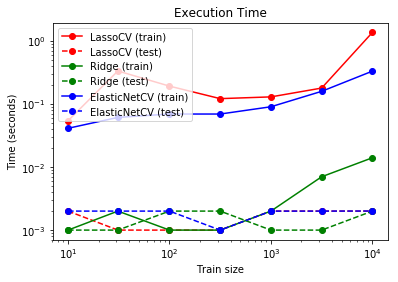

In [20]:
# Visualize training and prediction time
plt.figure()
colors_dict = {"LassoCV":"r",
               "Ridge": "g", 
               "ElasticNetCV": "b"}
for name, estimator in {"LassoCV": lassocv,
                        "Ridge": ridge, 
                        "ElasticNetCV": elasticnetcv}.items():
    train_time = []
    test_time = []
    sizes = np.logspace(1, 4, 7).astype(np.int)
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X = X_train[:train_test_size],y = np.log1p(y_train[:train_test_size]))
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X=X_validate)
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color=colors_dict[name],
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color = colors_dict[name],
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

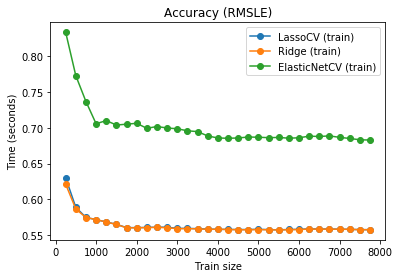

In [23]:
# Visualize learning curves
plt.figure()

lassocv = LassoCV(eps=1e-7, cv=5, max_iter=1000)
ridge = Ridge(alpha=1e-6, max_iter=1000)
elasticnetcv = ElasticNetCV(max_iter=1000, cv=5)

sizes = []
x = 0
while x<7620 : 
    x+=250 
    sizes.append(x)

sizes = np.array(sizes)
    
for name, estimator in {"LassoCV": lassocv,
                        "Ridge": ridge, 
                        "ElasticNetCV": elasticnetcv}.items():
    train_time = []
    test_time = []
    res = []
    for train_test_size in sizes:
        estimator.fit(X = X_train[:train_test_size],y = np.log1p(y_train[:train_test_size]))
        preds = estimator.predict(X=X_validate)
        res.append(performance_metric(np.exp(np.log1p(y_validate)),np.exp(preds),False))


    plt.plot(sizes, res, 'o-', label="%s (train)" % name)
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Accuracy (RMSLE)')
plt.legend(loc="best")

In [24]:
for model in linear_models:
    preds = model.predict(X= X_validate)
    print ("RMSLE Value For ", str(model), " : ") 
    print (performance_metric(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For  LassoCV(alphas=None, copy_X=True, cv=5, eps=1e-07, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)  : 
0.557500049232119
RMSLE Value For  Ridge(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)  : 
0.5574870195546555
RMSLE Value For  ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)  : 
0.6830061732609689


In [25]:
features = X_train.columns
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 53 features over 60
Ridge regression has conserved 60 features over 60
ElasticNetCV regression has conserved 35 features over 60


# 4. Модели основанные на деревьях

In [ ]:
!pip install xgboost 
import xgboost as xgb
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

model_xgb.fit(X = X_train,y = np.log1p(y_train))
preds = model_xgb.predict(X_validate)
print ("Perfomance metric for xboost: ",performance_metric(np.exp(np.log1p(y_validate)),np.exp(preds),False))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost.fit(X = X_train,y = np.log1p(y_train))
preds = GBoost.predict(X_validate)
print ("Perfomance metric for GBoost: ",performance_metric(np.exp(np.log1p(y_validate)),np.exp(preds),False))

In [ ]:
import lightgbm as lgb
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

LightGB.fit(X = X_train,y = np.log1p(y_train))
preds = LightGB.predict(X_validate)
print ("Perfomance metric for LightGB: ",performance_metric(np.exp(np.log1p(y_validate)),np.exp(preds),False))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) 
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_validate)
print ("Perfomance metric for Random Forest: ",performance_metric(np.exp(np.log1p(y_validate)),np.exp(preds),False))

In [ ]:
preds = GBoost.predict(X= dataTest)

In [ ]:
submission = pd.DataFrame({
        "datetime": datetime,
        "count": [max(0, x) for x in np.exp(preds)]
    })
submission.to_csv('bike_prediction_output.csv', index=False)

# 5. Построение кривых обучения